## **Feature Extraction/Engineering + Classical ML for comparison**

*Run on Google Colaboratory VM*

**See [THIS LINK](https://nbviewer.org/github/kstoudt/Springboard/blob/main/Final_Capstone/Notebooks/Final_Capstone_Feature_Engineering_%26_Classical_ML.ipynb) to view fully-functioning notebook on nbviewer.org**

# Imports & Filepathing

In [1]:
import os
import itertools

# !pip install librosa
import librosa as lr
print(f"Notebook run using Librosa version {lr.__version__}")

from librosa.display import waveplot, specshow
from librosa.core.spectrum import amplitude_to_db
from librosa.feature import melspectrogram
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import pandas as pd
import numpy as np

from timeit import default_timer as timer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Notebook run using Librosa version 0.8.1


In [2]:
!ls '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples' # CORRUPTED_FILES simply contains a faulty jazz song discovered and replaced later

blues	   CORRUPTED_FILES  disco   jazz   pop	   rock
classical  country	    hiphop  metal  reggae  song_features.csv


In [3]:
!ls '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms'

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [4]:
bluesPath = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/blues/*.wav'
classicalPath = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/classical/*.wav'
countryPath = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/country/*.wav'
discoPath = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/disco/*.wav'
hiphopPath = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/hiphop/*.wav'
jazzPath = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/jazz/*.wav'
metalPath = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/metal/*.wav'
popPath = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/pop/*.wav'
reggaePath = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/reggae/*.wav'
rockPath = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/rock/*.wav'

In [5]:
blues_songs = glob(bluesPath)
classical_songs = glob(classicalPath)
country_songs = glob(countryPath)
disco_songs = glob(discoPath)
hiphop_songs = glob(hiphopPath)
jazz_songs = glob(jazzPath)
metal_songs = glob(metalPath)
pop_songs = glob(popPath)
reggae_songs = glob(reggaePath)
rock_songs = glob(rockPath)

genre_dict = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
              'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

In [6]:
'''
def mel_spec(files, num):
  file = files[num - 1]
  audio, sr = lr.load(file)
  time = np.arange(0, len(audio)) / sr
  audio_melspec = melspectrogram(audio, sr=sr)
  melspec_db = amplitude_to_db(np.abs(audio_melspec))
  plt.title(file + '\nMEL SPECTROGRAM:')
  specshow(melspec_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma');
''';

def wave_view(files, num, lw=1):
  file = files[num - 1]
  a, s = lr.load(file)
  plt.title(file + '\nWAVEPLOT:')
  waveplot(a, linewidth=lw);

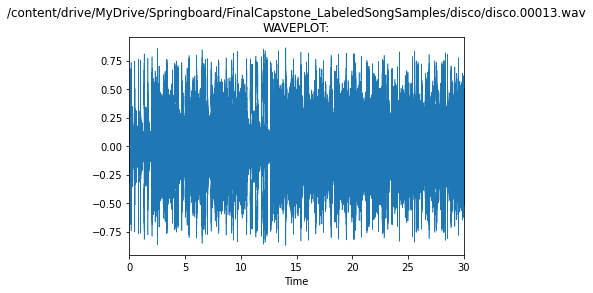

In [7]:
_ = wave_view(disco_songs, 4, lw=0.6)

# Data Loading and Feature Extraction:

In [8]:
def get_features(song, genre=None, n_fft=1024, hop_length=512):
  y, sr = lr.load(song)
  
  # Get feature vectors from audio data
  features = {}
  features['centroid'] = lr.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
  features['bandwidth'] = lr.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
  features['contrast'] = lr.feature.spectral_contrast(y, sr=sr).ravel()
  features['flatness'] = lr.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
  features['roloff'] = lr.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
  features['zcr'] = lr.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
  features['rmse'] = lr.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
  features['flux'] = lr.onset.onset_strength(y=y, sr=sr).ravel()
  
  # Calculate feature vecs statistical moments
  def get_moments(feature_vec_dict):
    res = {}
    for key, val in feature_vec_dict.items():
      res['{}_max'.format(key)] = np.max(val)
      res['{}_min'.format(key)] = np.min(val)
      res['{}_mean'.format(key)] = np.mean(val)
      res['{}_std'.format(key)] = np.std(val)
      res['{}_kurtosis'.format(key)] = kurtosis(val)
      res['{}_skew'.format(key)] = skew(val)
    return res
  
  # Finally, assemble feature dict per song, append tempo
  feature_dict = get_moments(features)
  feature_dict['tempo'] = lr.beat.tempo(y, sr=sr)[0]
  feature_dict['genre'] = genre

  return feature_dict

In [9]:
song_dict = get_features(blues_songs[0], 'blues')
dict(itertools.islice(song_dict.items(), 15))

{'centroid_max': 4709.894987472859,
 'centroid_min': 356.7356446956628,
 'centroid_mean': 1493.9254357661255,
 'centroid_std': 419.35203752342926,
 'centroid_kurtosis': 11.337517836363963,
 'centroid_skew': 1.898859253938905,
 'bandwidth_max': 2657.716270552206,
 'bandwidth_min': 866.9156910612787,
 'bandwidth_mean': 1698.9430165681247,
 'bandwidth_std': 306.900629996694,
 'bandwidth_kurtosis': 0.005636735868835618,
 'bandwidth_skew': 0.1898252318031489,
 'contrast_max': 67.98005563611429,
 'contrast_min': 4.558865224169454,
 'contrast_mean': 22.197516533033788}

In [10]:
def genre_features(songlist, genre=None):
  list_of_feature_dicts = []
  
  # time to iterate
  for song in songlist:
    list_of_feature_dicts.append(get_features(song, genre))
  
  genre_df = pd.DataFrame(list_of_feature_dicts)
  return genre_df

In [11]:
start = timer()

blues_df = genre_features(blues_songs, 'blues')

end = timer()
print(f'{round(end - start)} seconds elapsed.')

67 seconds elapsed.


In [12]:
blues_df.sample(5)

centroid_max  centroid_min  centroid_mean  centroid_std  \
64   4085.372088   1659.636784    2498.482060    358.399115   
23   3454.796715    324.398552    1083.501868    536.975252   
63   4094.689039    378.769105    1206.750695    611.434242   
41   2556.475778    531.892914    1308.606790    432.409493   
73   3649.877612    985.207995    1894.201092    377.012086   

    centroid_kurtosis  centroid_skew  bandwidth_max  bandwidth_min  \
64           1.896685       1.002869    2919.412467    1841.797702   
23           1.230349       1.160549    2208.144625     781.239878   
63           3.492773       1.650584    3166.876116     920.917337   
41          -0.456402       0.570283    2307.199042    1034.585140   
73           0.358365       0.243387    2730.470625    1328.961873   

    bandwidth_mean  bandwidth_std  ...  rmse_kurtosis  rmse_skew   flux_max  \
64     2261.267192     193.341651  ...      -0.468954  -0.339873   7.139411   
23     1451.249472     256.709800  ...       1.827652   1.114239  11.214520   
63     1824.249278     422.181848  ...       0.612756   0.335293  19.460062   
41     1458.786547     212.573750  ...       0.291038   0.728781   9.123614   
73     1960.703970     246.052060  ...      -0.428425   0.422767   7.187864   

    flux_min  flux_mean  flux_std  flux_kurtosis  flux_skew       tempo  genre  
64       0.0   1.270983  1.054085       3.996071   1.859237  151.999081  blues  
23       0.0   1.528981  1.789629       4.951525   2.159645   99.384014  blues  
63       0.0   1.115350  1.587036      28.500367   4.586152  123.046875  blues  
41       0.0   1.321388  1.192495       5.523621   2.071176   95.703125  blues  
73       0.0   1.347559  1.185104       2.702346   1.615542  151.999081  blues  

[5 rows x 50 columns]

In [13]:
'''
import scipy.io
from scipy.io import wavfile

y, sr = wavfile.read("/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/jazz/jazz.00054.wav")
''';
# ValueError: File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF' and 'RIFX' supported.

# soundfile and audioread failing to load this file as well.

**Faulty jazz.00054.wav file replaced with option found [here](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/discussion/158649):**

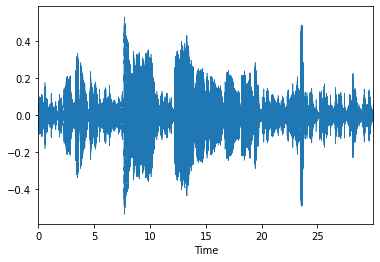

In [14]:
# Taking a look at the replacement file:
waveplot(lr.load('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/jazz/jazz.00054.wav')[0], linewidth=0.6);

In [15]:
import IPython.display as ipd

# Listen to replacement file for reassurance:
ipd.Audio('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/jazz/jazz.00054.wav')

In [16]:
classical_df = genre_features(classical_songs, 'classical')
country_df = genre_features(country_songs, 'country')
disco_df = genre_features(disco_songs, 'disco')
hiphop_df = genre_features(hiphop_songs, 'hiphop')
jazz_df = genre_features(jazz_songs, 'jazz')
metal_df = genre_features(metal_songs, 'metal')
pop_df = genre_features(pop_songs, 'pop')
reggae_df = genre_features(reggae_songs, 'reggae')
rock_df = genre_features(rock_songs, 'rock')

In [17]:
blues_df.shape, classical_df.shape, disco_df.shape, hiphop_df.shape, jazz_df.shape, metal_df.shape, pop_df.shape, reggae_df.shape, rock_df.shape

((100, 50),
 (100, 50),
 (100, 50),
 (100, 50),
 (100, 50),
 (100, 50),
 (100, 50),
 (100, 50),
 (100, 50))

In [18]:
merge_1 = pd.concat([blues_df, classical_df], ignore_index=True)
print(merge_1.shape)
merge_1.iloc[95:105,:]

(200, 50)


centroid_max  centroid_min  centroid_mean  centroid_std  \
95    3715.630228    275.593641    1148.082499    634.411013   
96    5379.846466    401.397351    1049.267868    544.236165   
97    4386.972171   1031.810602    2052.948349    385.242679   
98    3994.234685   1032.053918    2235.538844    419.375618   
99    4152.928614    228.475668     534.046982    292.199809   
100   2246.645799    772.256861    1316.454335    251.191286   
101   2477.447834    895.149523    1463.063817    218.171419   
102   2756.543451    637.450618    1315.360780    326.553231   
103   2188.742524    718.690386    1318.110181    265.193233   
104   2374.013435    702.031332    1443.260690    287.352031   

     centroid_kurtosis  centroid_skew  bandwidth_max  bandwidth_min  \
95            0.820121       1.119065    2984.673051     619.977215   
96           19.084295       3.642512    3142.013112     738.546942   
97            2.822624       1.008686    3102.537765    1407.620159   
98           -0.110159       0.064020    3285.806401    1657.559688   
99           81.656557       8.013321    3127.804419     530.787219   
100           0.012089       0.415874    2129.615732     922.748636   
101           0.422851       0.390027    2331.782761     915.485118   
102           0.109440       0.653077    2481.646309     766.901693   
103          -0.373303       0.387399    2229.120890     973.561237   
104           0.048298      -0.164696    2447.023995    1036.364785   

     bandwidth_mean  bandwidth_std  ...  rmse_kurtosis  rmse_skew   flux_max  \
95      1532.861585     542.786563  ...      -0.244409   0.404809   9.888046   
96      1489.011849     395.694830  ...       1.022973   0.949578  12.231086   
97      2118.651352     299.993640  ...      -0.546255  -0.135447  13.039564   
98      2221.433917     205.711780  ...       0.945645   0.906241   7.184466   
99       924.350936     276.494227  ...       2.863040   1.471056  18.117476   
100     1399.540240     188.524146  ...       0.955169   0.922008   4.205564   
101     1526.916082     221.608544  ...       2.633673   1.276604   5.739889   
102     1394.610798     285.921040  ...      -0.466026   0.895907   6.976985   
103     1537.074353     189.218881  ...       2.370971   1.291329   3.395458   
104     1535.852705     226.444474  ...       1.022716   1.015885   5.915265   

     flux_min  flux_mean  flux_std  flux_kurtosis  flux_skew       tempo  \
95        0.0   1.614638  1.635529       3.796568   1.860467  117.453835   
96        0.0   1.108238  1.199263      18.177394   3.509790  123.046875   
97        0.0   1.454709  1.271468      10.069149   2.538735  123.046875   
98        0.0   1.469209  1.325956       1.111249   1.254170  135.999178   
99        0.0   0.813978  1.357986      65.346499   7.057296  143.554688   
100       0.0   0.911794  0.483105       6.483631   2.180592  117.453835   
101       0.0   1.077419  0.727404       4.024367   1.848860   95.703125   
102       0.0   1.103384  0.781201       7.258357   2.285266  135.999178   
103       0.0   0.868831  0.376269       7.897838   2.294019  103.359375   
104       0.0   1.080754  0.828979       7.418667   2.467871  103.359375   

         genre  
95       blues  
96       blues  
97       blues  
98       blues  
99       blues  
100  classical  
101  classical  
102  classical  
103  classical  
104  classical  

[10 rows x 50 columns]

In [19]:
song_features_df = pd.concat([merge_1, country_df, disco_df, hiphop_df, jazz_df, metal_df, pop_df, reggae_df, rock_df], ignore_index=True)
print(song_features_df.shape)
song_features_df.iloc[-5:,:]

(1000, 50)


centroid_max  centroid_min  centroid_mean  centroid_std  \
995   4151.205944    463.391600    1314.911489    495.550847   
996   5214.752621    904.425678    2379.158989    528.898586   
997   6224.041865    684.855531    2416.941484    790.971618   
998   4153.387810   1676.587715    2409.512960    348.762356   
999   4295.291893    746.216989    2016.655016    484.378885   

     centroid_kurtosis  centroid_skew  bandwidth_max  bandwidth_min  \
995           3.614385       1.452547    3115.894041     991.581398   
996           1.858400       0.759082    3054.026388    1548.059882   
997           4.617060       1.702872    3234.012931    1203.373207   
998           1.970302       1.002418    2874.678502    1599.418516   
999           3.688971       1.362812    2879.330737    1213.388905   

     bandwidth_mean  bandwidth_std  ...  rmse_kurtosis  rmse_skew   flux_max  \
995     1750.744149     346.199915  ...      -0.144923  -0.644295   8.862420   
996     2219.621575     208.730078  ...      -0.405752  -0.649752   6.804705   
997     2101.366330     332.804166  ...      -0.981799   0.361228  13.441139   
998     2085.981684     174.652738  ...      -0.294028   0.128975   6.224658   
999     1899.322055     279.749449  ...      -0.278727   0.437698   9.953552   

     flux_min  flux_mean  flux_std  flux_kurtosis  flux_skew       tempo  \
995       0.0   1.151901  1.043499       9.017186   2.626594  112.347147   
996       0.0   1.309105  1.047612       4.501188   1.987946  123.046875   
997       0.0   1.446754  1.662604       7.488685   2.481091  129.199219   
998       0.0   1.130423  0.957580       5.103566   2.135034  129.199219   
999       0.0   1.056053  0.839705      15.817138   3.049973  129.199219   

     genre  
995   rock  
996   rock  
997   rock  
998   rock  
999   rock  

[5 rows x 50 columns]

In [20]:
song_features_df.flux_min.value_counts()

0.0    1000
Name: flux_min, dtype: int64

In [21]:
song_features_df = song_features_df.drop(columns=['flux_min'])
song_features_df.shape

(1000, 49)

In [22]:
song_features_df.to_csv('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/song_features.csv')
# Default Index=True

# EDA of Tabular Data:

In [23]:
genre_means = song_features_df.groupby('genre').apply(lambda x: np.mean(x))
genre_means[['centroid_mean', 'bandwidth_mean', 'contrast_mean', 'flatness_mean', 'roloff_mean', 'zcr_mean', 'rmse_mean', 'flux_mean', 'tempo']]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


centroid_mean  bandwidth_mean  contrast_mean  flatness_mean  \
genre                                                                    
blues        1647.469936     1880.647477      22.479541       0.003848   
classical    1296.254131     1465.060875      22.024022       0.002590   
country      1783.109581     2028.853575      21.692997       0.014110   
disco        2508.112680     2458.297745      19.983307       0.033806   
hiphop       2422.198262     2463.377556      18.946314       0.030731   
jazz         1711.805638     1961.853959      21.280564       0.011479   
metal        2535.862529     2224.877113      20.326933       0.018380   
pop          2922.551777     2947.710721      18.295081       0.058453   
reggae       2037.998409     2221.414716      19.820887       0.023870   
rock         2141.223828     2211.005088      20.433467       0.020741   

           roloff_mean  zcr_mean  rmse_mean  flux_mean       tempo  
genre                                                               
blues      3453.741758  0.078961   0.133980   1.389011  123.879492  
classical  2356.950352  0.077604   0.042594   0.998595  125.852694  
country    3706.424984  0.083393   0.124919   1.257509  120.651245  
disco      5292.293913  0.129352   0.133051   1.587905  120.045298  
hiphop     5118.830390  0.107964   0.174024   1.818747  110.208859  
jazz       3554.231360  0.077412   0.084554   1.213627  119.539697  
metal      5033.433693  0.147449   0.152048   1.171830  123.847177  
pop        6351.300864  0.133548   0.196114   1.625878  113.858838  
reggae     4264.686684  0.091551   0.119294   1.827799  132.743619  
rock       4462.473486  0.109229   0.126050   1.281184  120.191673

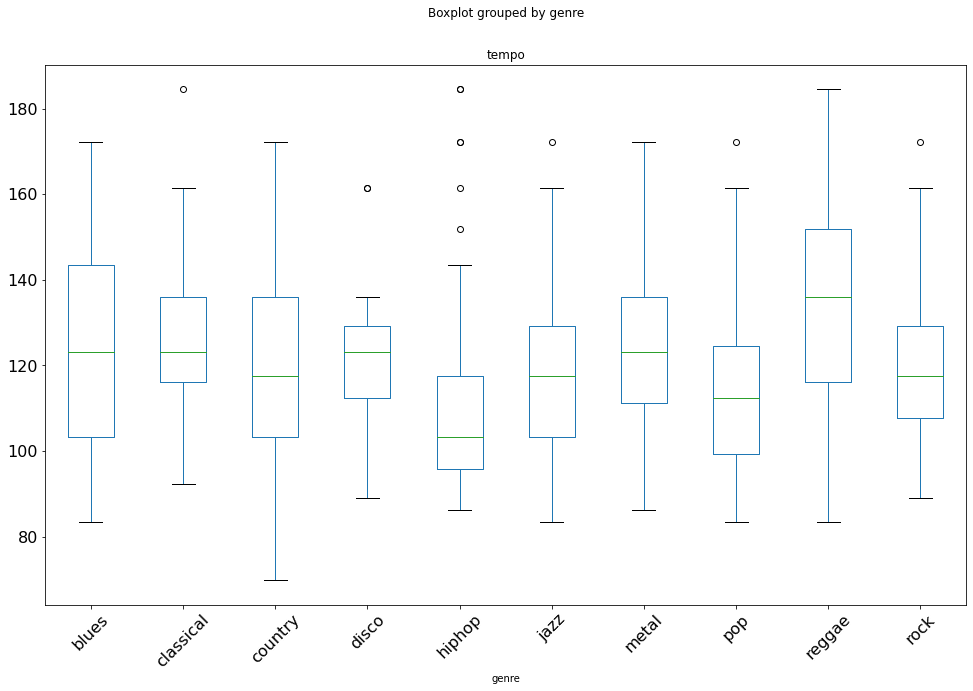

In [24]:
_ = song_features_df.boxplot(column=['tempo'], by='genre', rot=45, grid=False, figsize=(16,10), fontsize=16)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


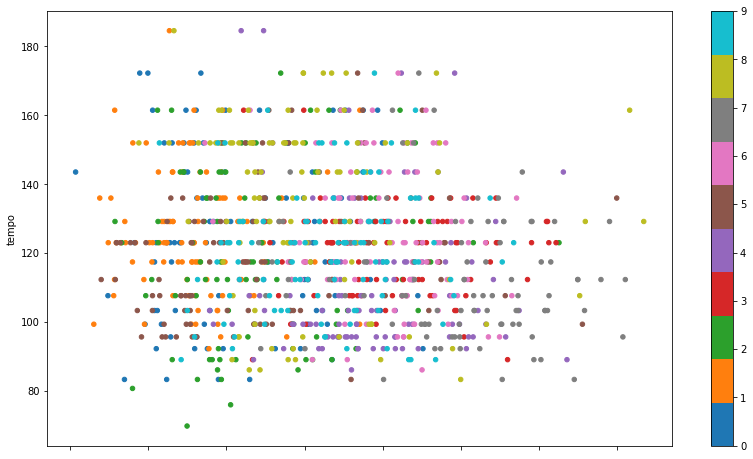

In [25]:
numeric_genres = song_features_df.genre.replace(genre_dict)

_ = song_features_df.plot(kind='scatter', x='centroid_mean', y='tempo', figsize=(14,8), c=numeric_genres, colorbar=True, cmap='tab10')
print(genre_dict)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


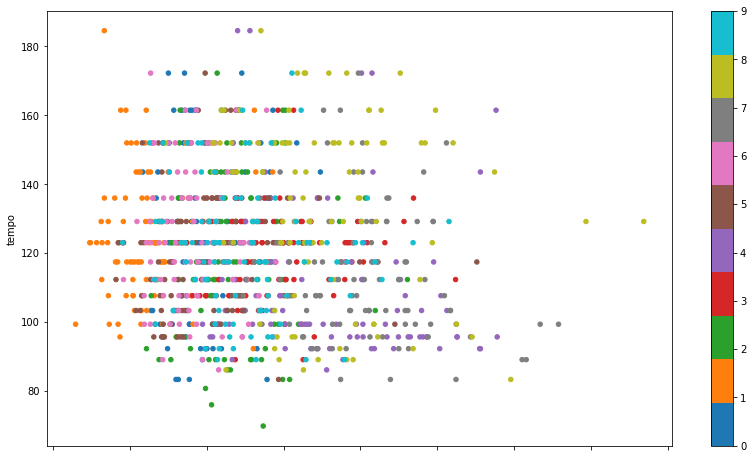

In [26]:
_ = song_features_df.plot(kind='scatter', x='centroid_std', y='tempo', figsize=(14,8), c=numeric_genres, colorbar=True, cmap='tab10')
print(genre_dict)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


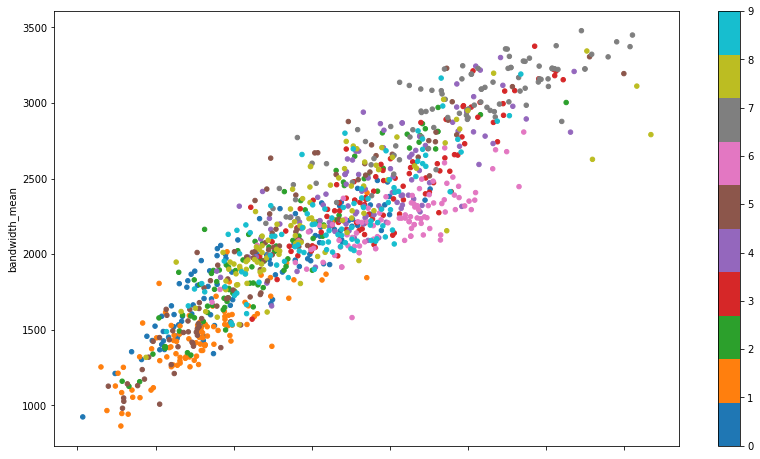

In [27]:
_ = song_features_df.plot(kind='scatter', x='centroid_mean', y='bandwidth_mean', figsize=(14,8), c=numeric_genres, colorbar=True, cmap='tab10')
print(genre_dict)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


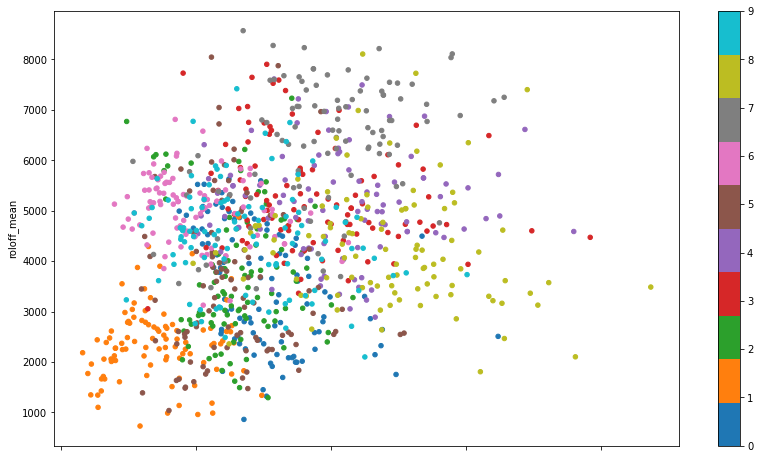

In [28]:
_ = song_features_df.plot(kind='scatter', x='flux_std', y='roloff_mean', figsize=(14,8), c=numeric_genres, colorbar=True, cmap='tab10')
print(genre_dict)

# Pre-processing:

In [29]:
X = song_features_df.drop(columns=['genre'])
y = song_features_df[['genre']].values.ravel()
X.shape, y.shape

((1000, 48), (1000,))

In [30]:
X.describe().T.head(8)

count         mean          std          min          25%  \
centroid_max       1000.0  4945.786178  1570.936286  1066.082988  3911.913688   
centroid_min       1000.0   768.235367   419.105919     0.000000   461.198307   
centroid_mean      1000.0  2100.658677   697.767231   534.046982  1520.864167   
centroid_std       1000.0   651.356898   279.640719    73.853662   440.409059   
centroid_kurtosis  1000.0     2.161673     3.803902    -1.782080     0.258085   
centroid_skew      1000.0     0.957221     0.694151    -0.970403     0.520136   
bandwidth_max      1000.0  3354.836722   599.083782  1611.326077  2975.121189   
bandwidth_min      1000.0  1241.426100   425.600143     0.000000   921.693104   

                           50%          75%          max  
centroid_max       4870.932887  6020.440215  8917.188266  
centroid_min        673.066829  1000.672073  2239.022284  
centroid_mean      2112.958377  2613.219953  4171.532799  
centroid_std        600.695964   813.856939  1921.069855  
centroid_kurtosis     1.266501     2.917455    81.656557  
centroid_skew         0.874226     1.291089     8.013321  
bandwidth_max      3332.180942  3840.459738  4610.306298  
bandwidth_min      1245.018159  1551.491449  2654.860033

In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pd.DataFrame(X_scaled, columns=X.keys()).describe().T.head(8)

count          mean     std       min       25%       50%  \
centroid_max       1000.0  9.947598e-17  1.0005 -2.470911 -0.658454 -0.047673   
centroid_min       1000.0 -2.131628e-16  1.0005 -1.833951 -0.732967 -0.227189   
centroid_mean      1000.0 -1.136868e-16  1.0005 -2.246302 -0.831344  0.017636   
centroid_std       1000.0 -3.268497e-16  1.0005 -2.066195 -0.754731 -0.181255   
centroid_kurtosis  1000.0 -5.684342e-17  1.0005 -1.037284 -0.500681 -0.235448   
centroid_skew      1000.0  1.136868e-16  1.0005 -2.778342 -0.629984 -0.119624   
bandwidth_max      1000.0 -2.557954e-16  1.0005 -2.911751 -0.634144 -0.037836   
bandwidth_min      1000.0 -1.278977e-16  1.0005 -2.918343 -0.751628  0.008444   

                        75%        max  
centroid_max       0.684427   2.529313  
centroid_min       0.554879   3.511100  
centroid_mean      0.734941   2.969343  
centroid_std       0.581394   4.542787  
centroid_kurtosis  0.198785  20.908703  
centroid_skew      0.481214  10.170164  
bandwidth_max      0.811015   2.096698  
bandwidth_min      0.728901   3.322699

In [32]:
pca = PCA(n_components=20, whiten=True) # whiten to get the most discerning components for visualization
X_pca = pca.fit_transform(X_scaled)
print(X_pca.shape)
print("cumulative explained variance ratio = ", np.sum(pca.explained_variance_ratio_))

(1000, 20)
cumulative explained variance ratio =  0.9579760848269793


In [33]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
X_tsne = tsne.fit_transform(X_scaled)
X_tsne.shape

(1000, 2)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


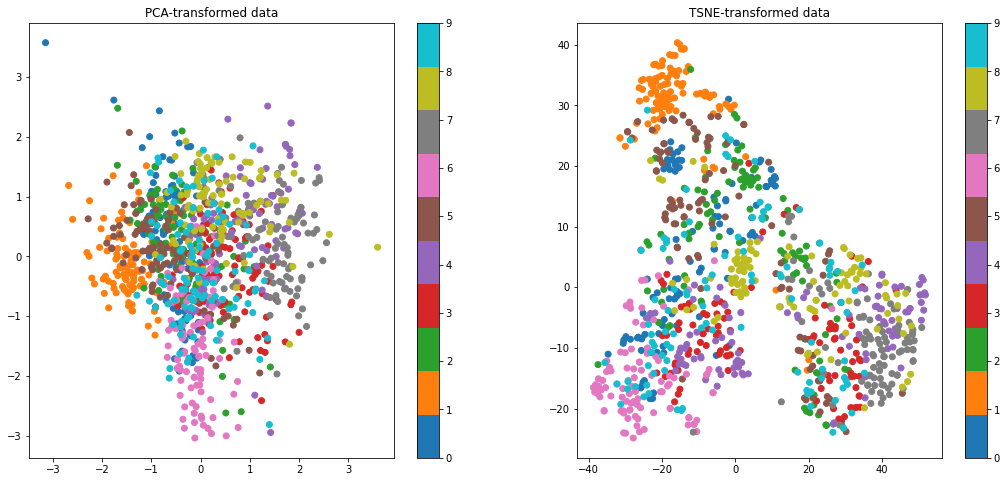

In [34]:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.scatter(X_pca[:,0], X_pca[:,1], c=numeric_genres, cmap='tab10')
plt.colorbar()
plt.title("PCA-transformed data")

plt.subplot(122)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=numeric_genres, cmap='tab10')
plt.colorbar()
plt.title("TSNE-transformed data")
print(genre_dict)
plt.show()

# Classical ML:

## Train-Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 48), (200, 48), (800,), (200,))

## K-Nearest Neighbors

In [36]:
knn = KNeighborsClassifier()

params = {'n_neighbors': [5, 10, 20, 40],
          'leaf_size': [10, 20, 30],
          'p': [1, 2]}

knn_cv = GridSearchCV(knn, params, scoring='f1_macro', cv=5, n_jobs=-1)

knn_cv = knn_cv.fit(X_train, y_train)

print("Best Score:{}".format(str(knn_cv.best_score_)))
print("Best Parameters:{}".format(str(knn_cv.best_params_)))

Best Score:0.6038490131448616
Best Parameters:{'leaf_size': 10, 'n_neighbors': 10, 'p': 1}


In [37]:
y_pred = knn_cv.predict(X_test)
print(classification_report(y_test, y_pred, labels=knn_cv.classes_))

              precision    recall  f1-score   support

       blues       0.69      0.55      0.61        20
   classical       0.72      0.90      0.80        20
     country       0.57      0.80      0.67        20
       disco       0.41      0.55      0.47        20
      hiphop       0.82      0.45      0.58        20
        jazz       0.69      0.55      0.61        20
       metal       0.58      0.55      0.56        20
         pop       0.73      0.80      0.76        20
      reggae       0.64      0.70      0.67        20
        rock       0.43      0.30      0.35        20

    accuracy                           0.61       200
   macro avg       0.63      0.61      0.61       200
weighted avg       0.63      0.61      0.61       200



In [38]:
auc_score_tr = roc_auc_score(y_train, knn_cv.predict_proba(X_train), multi_class='ovr') # One vs rest should be representative with balanced classes
auc_score_te = roc_auc_score(y_test, knn_cv.predict_proba(X_test), multi_class='ovr')

print('Train AUC:', auc_score_tr)
print('Test AUC:', auc_score_te)

Train AUC: 0.9654722222222223
Test AUC: 0.9124583333333331


In [39]:
knn_metrics = {
    'KNearestNeighbors': [classification_report(y_test, y_pred, labels=knn_cv.classes_, output_dict=True)['accuracy'],
                          knn_cv.best_score_,
                          classification_report(y_test, y_pred, labels=knn_cv.classes_, output_dict=True)['macro avg']['f1-score'],
                          auc_score_tr,
                          auc_score_te]
    }

## Logistic Regression

In [40]:
start = timer()

lr = LogisticRegression()

params = {'penalty': ['l1', 'l2'],
          'C': [0.5, 1, 2, 5, 10],
          'max_iter': [600],
          'solver': ['liblinear']} # liblinear is a good optimizer for small datasets

lr_cv = GridSearchCV(lr, params, scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)

lr_cv = lr_cv.fit(X_train, y_train)

end = timer()
print(f'{round(end - start)} seconds elapsed.')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
21 seconds elapsed.


In [41]:
print("Best Score:{}".format(str(lr_cv.best_score_)))
print("Best Parameters:{}".format(str(lr_cv.best_params_)))

Best Score:0.6855774979445078
Best Parameters:{'C': 10, 'max_iter': 600, 'penalty': 'l2', 'solver': 'liblinear'}


In [42]:
y_pred = lr_cv.predict(X_test)
print(classification_report(y_test, y_pred, labels=lr_cv.classes_))

              precision    recall  f1-score   support

       blues       0.59      0.65      0.62        20
   classical       0.88      0.75      0.81        20
     country       0.57      0.60      0.59        20
       disco       0.67      0.70      0.68        20
      hiphop       0.85      0.85      0.85        20
        jazz       0.62      0.80      0.70        20
       metal       0.79      0.75      0.77        20
         pop       0.80      0.80      0.80        20
      reggae       0.71      0.85      0.77        20
        rock       0.50      0.25      0.33        20

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.69       200
weighted avg       0.70      0.70      0.69       200



In [43]:
auc_score_tr = roc_auc_score(y_train, lr_cv.predict_proba(X_train), multi_class='ovr')
auc_score_te = roc_auc_score(y_test, lr_cv.predict_proba(X_test), multi_class='ovr')

print('Train AUC:', auc_score_tr)
print('Test AUC:', auc_score_te)

Train AUC: 0.979939236111111
Test AUC: 0.9497499999999999


In [44]:
lr_metrics = {
    'LogisticRegression': [classification_report(y_test, y_pred, labels=lr_cv.classes_, output_dict=True)['accuracy'],
                           lr_cv.best_score_,
                           classification_report(y_test, y_pred, labels=lr_cv.classes_, output_dict=True)['macro avg']['f1-score'],
                           auc_score_tr,
                           auc_score_te]
    }

## Support Vector Machine

In [45]:
start = timer()

svc = svm.SVC(random_state=42)

params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'C': [0.5, 1, 5, 10, 20],
          'decision_function_shape': ['ovo','ovr'],
          'probability': [True]}

svc_cv = GridSearchCV(svc, params, scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)

svc_cv = svc_cv.fit(X_train, y_train)

end = timer()
print(f'{round(end - start)} seconds elapsed.')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
30 seconds elapsed.


In [46]:
print("Best Score:{}".format(str(svc_cv.best_score_)))
print("Best Parameters:{}".format(str(svc_cv.best_params_)))

Best Score:0.7107269150068929
Best Parameters:{'C': 10, 'decision_function_shape': 'ovo', 'kernel': 'rbf', 'probability': True}


In [47]:
y_pred = svc_cv.predict(X_test)
print(classification_report(y_test, y_pred, labels=svc_cv.classes_))

              precision    recall  f1-score   support

       blues       0.71      0.60      0.65        20
   classical       0.84      0.80      0.82        20
     country       0.65      0.65      0.65        20
       disco       0.62      0.75      0.68        20
      hiphop       0.88      0.75      0.81        20
        jazz       0.73      0.80      0.76        20
       metal       0.75      0.75      0.75        20
         pop       0.67      0.80      0.73        20
      reggae       0.68      0.85      0.76        20
        rock       0.50      0.30      0.37        20

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.70      0.70      0.70       200



In [48]:
auc_score_tr = roc_auc_score(y_train, svc_cv.predict_proba(X_train), multi_class='ovr')
auc_score_te = roc_auc_score(y_test, svc_cv.predict_proba(X_test), multi_class='ovr')

print('Train AUC:', auc_score_tr)
print('Test AUC:', auc_score_te)

Train AUC: 0.9999878472222223
Test AUC: 0.9568888888888887


In [49]:
svc_metrics = {
    'SVM': [classification_report(y_test, y_pred, labels=svc_cv.classes_, output_dict=True)['accuracy'],
            svc_cv.best_score_,
            classification_report(y_test, y_pred, labels=svc_cv.classes_, output_dict=True)['macro avg']['f1-score'],
            auc_score_tr,
            auc_score_te]
    }

## XGBoost Classifier

In [50]:
start = timer()

xgclf = xgb.XGBClassifier()

params = {'learning_rate': [0.1, 0.5, 1],
          'n_estimators': [50, 100],
          'gamma': [0.1, 0.5],
          'max_depth': [3, 5, 8]}

xgb_cv = GridSearchCV(xgclf, params, scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)

xgb_cv = xgb_cv.fit(X_train, y_train)

end = timer()
print(f'{round((end - start)/60, 2)} minutes elapsed.')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
4.48 minutes elapsed.


In [51]:
print("Best Score:{}".format(str(xgb_cv.best_score_)))
print("Best Parameters:{}".format(str(xgb_cv.best_params_)))

Best Score:0.6868906842093553
Best Parameters:{'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [52]:
y_pred = xgb_cv.predict(X_test)
print(classification_report(y_test, y_pred, labels=xgb_cv.classes_))

              precision    recall  f1-score   support

       blues       0.67      0.60      0.63        20
   classical       0.83      0.75      0.79        20
     country       0.63      0.85      0.72        20
       disco       0.75      0.75      0.75        20
      hiphop       0.80      0.80      0.80        20
        jazz       0.62      0.65      0.63        20
       metal       0.81      0.85      0.83        20
         pop       0.89      0.80      0.84        20
      reggae       0.78      0.90      0.84        20
        rock       0.43      0.30      0.35        20

    accuracy                           0.73       200
   macro avg       0.72      0.73      0.72       200
weighted avg       0.72      0.72      0.72       200



In [53]:
auc_score_tr = roc_auc_score(y_train, xgb_cv.predict_proba(X_train), multi_class='ovr')
auc_score_te = roc_auc_score(y_test, xgb_cv.predict_proba(X_test), multi_class='ovr')

print('Train AUC:', auc_score_tr)
print('Test AUC:', auc_score_te)

Train AUC: 1.0
Test AUC: 0.9518888888888888


In [54]:
xgb_metrics = {
    'XGBoost': [classification_report(y_test, y_pred, labels=xgb_cv.classes_, output_dict=True)['accuracy'],
                xgb_cv.best_score_,
                classification_report(y_test, y_pred, labels=xgb_cv.classes_, output_dict=True)['macro avg']['f1-score'],
                auc_score_tr,
                auc_score_te]
    }

## Gradient Boosting Classifier

In [55]:
start = timer()

gbc = GradientBoostingClassifier(random_state=42)

params = {'loss': ['deviance'],
          'learning_rate': [0.1, 1],
          'n_estimators': [50, 100],
          'max_depth': [3, 4, 5]}

gbc_cv = GridSearchCV(gbc, params, scoring='f1_macro', cv=5, verbose=1, n_jobs=-1)

gbc_cv = gbc_cv.fit(X_train, y_train)

end = timer()
print(f'{round((end - start)/60, 2)} minutes elapsed.')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
5.61 minutes elapsed.


In [56]:
print("Best Score:{}".format(str(gbc_cv.best_score_)))
print("Best Parameters:{}".format(str(gbc_cv.best_params_)))

Best Score:0.6876052253578869
Best Parameters:{'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 100}


In [57]:
y_pred = gbc_cv.predict(X_test)
print(classification_report(y_test, y_pred, labels=gbc_cv.classes_))

              precision    recall  f1-score   support

       blues       0.74      0.70      0.72        20
   classical       0.83      0.75      0.79        20
     country       0.58      0.75      0.65        20
       disco       0.60      0.75      0.67        20
      hiphop       0.80      0.80      0.80        20
        jazz       0.71      0.60      0.65        20
       metal       0.81      0.85      0.83        20
         pop       0.75      0.75      0.75        20
      reggae       0.74      0.85      0.79        20
        rock       0.36      0.20      0.26        20

    accuracy                           0.70       200
   macro avg       0.69      0.70      0.69       200
weighted avg       0.69      0.70      0.69       200



In [58]:
auc_score_tr = roc_auc_score(y_train, gbc_cv.predict_proba(X_train), multi_class='ovr')
auc_score_te = roc_auc_score(y_test, gbc_cv.predict_proba(X_test), multi_class='ovr')

print('Train AUC:', auc_score_tr)
print('Test AUC:', auc_score_te)

Train AUC: 1.0
Test AUC: 0.9515277777777778


In [59]:
gbc_metrics = {
    'GradientBoostingClassifier': [classification_report(y_test, y_pred, labels=gbc_cv.classes_, output_dict=True)['accuracy'],
                                   gbc_cv.best_score_,
                                   classification_report(y_test, y_pred, labels=gbc_cv.classes_, output_dict=True)['macro avg']['f1-score'],
                                   auc_score_tr,
                                   auc_score_te]
    }

# Metrics Summary:

In [60]:
# Metrics compiled / summarized for classical models
mets_keys = ['accuracy', 'cv best f1', 'test macro avg f1', 'Train AUC', 'Test AUC']

mets_list = [knn_metrics, lr_metrics, svc_metrics, xgb_metrics, gbc_metrics]

mets_d = {}

for i in mets_list:
  mets_d.update(i)

In [61]:
metrics_df = pd.DataFrame.from_dict(mets_d, orient='index', columns = mets_keys)
metrics_df

accuracy  cv best f1  test macro avg f1  \
KNearestNeighbors              0.615    0.603849           0.608323   
LogisticRegression             0.700    0.685577           0.691909   
SVM                            0.705    0.710727           0.698152   
XGBoost                        0.725    0.686891           0.719013   
GradientBoostingClassifier     0.700    0.687605           0.690294   

                            Train AUC  Test AUC  
KNearestNeighbors            0.965472  0.912458  
LogisticRegression           0.979939  0.949750  
SVM                          0.999988  0.956889  
XGBoost                      1.000000  0.951889  
GradientBoostingClassifier   1.000000  0.951528

In [62]:
metrics_df.to_csv('/content/drive/MyDrive/Springboard/Classical_ML_Metrics.csv')